In [1]:
import numpy as np
np.random.seed(6)
from pybedtools import BedTool
import pybedtools
import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout,BatchNormalization,Activation
from keras.layers import Conv1D, MaxPooling1D,Conv2D,MaxPooling2D,GlobalAveragePooling1D, AveragePooling1D
from keras.layers import Dropout
from keras.optimizers import Adam,RMSprop
from keras import regularizers as kr
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.utils import np_utils, to_categorical
# custom R2-score metrics for keras backend
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt

import os
from sklearn.metrics import r2_score
from tensorflow.python.keras.callbacks import EarlyStopping

/home/AD/h5li/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#parameter setting...
cell_type = 5
apply_sample_weight = False
target_length = 600
filter_length = 6

In [3]:
def R2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot) )

In [4]:
def read_data(bed_file,fasta_file):
    #apply bedtools to read fasta files '/home/h5li/methylation_DMR/data/DMR_coordinates_extended_b500.bed'
    a = pybedtools.example_bedtool( bed_file )
    # '/home/h5li/methylation_DMR/data/mm10.fasta'
    fasta = pybedtools.example_filename( fasta_file )
    a = a.sequence(fi=fasta)
    seq = open(a.seqfn).read()
    #read and extract DNA sequences 
    DNA_seq_list = seq.split('\n')
    DNA_seq_list.pop()
    DNA_seq = []
    m = 10000
    n = 0
    for index in range(len(DNA_seq_list)//2):
        DNA_seq.append(DNA_seq_list[index*2 + 1].upper())
        if len(DNA_seq_list[index*2 + 1]) < m:
            m = len(DNA_seq_list[index*2 + 1])
        if len(DNA_seq_list[index*2 + 1]) > n:
            n = len(DNA_seq_list[index*2 + 1])
    print('The shortest length of DNA sequence is {0}bp'.format(m))
    print('The longest length of DNA sequence is {0}bp'.format(n))
    print('Total Number of input sequence is {0}'.format(len(DNA_seq)))
    return DNA_seq,n,m

In [5]:
def extend_Data(targetLength,dnaSeqList):
    newDNAList = []
    for seq in dnaSeqList:
        if len(seq) < targetLength:
            diff = targetLength - len(seq)
            if diff % 2 == 0:
                seq += 'N' * (diff//2)
                seq = 'N' * (diff//2) + seq
            if diff % 2 ==1:
                seq += 'N' *(diff//2)
                seq = 'N' * (diff//2 + 1) + seq
        newDNAList.append(seq)
    return newDNAList

def chop_Data(targetLength,dnaSeqList):
    #chop DNA sequences to have same length
    Uni_DNA = []
    for s in dnaSeqList:
        if len(s) < targetLength:
            print('Exceptions!')
        diff = len(s) - targetLength
        if diff % 2 == 0:
            side = diff // 2
            Uni_DNA.append(s[side:-side])
        else:
            right = diff // 2
            left = diff// 2 + 1
            Uni_DNA.append(s[left:-right])
    return Uni_DNA

In [6]:
#below are helper methods
def data_aug(seq):
    new_seq = []
    for i in range(len(seq)):
        l = seq[i]
        if l == 'A':
            new_seq.append( 'T' )
        elif l == 'C':
            new_seq.append( 'G' )
        elif l == 'G':
            new_seq.append( 'C' )
        elif l == 'T':
            new_seq.append( 'A' )
        else:
            new_seq.append( 'N' )
    return new_seq

def data_rev(seq):
    new_seq = [None] * len(seq)
    for i in range(len(seq)):
        new_seq[-i] = seq[i]
    return new_seq      

def mse_keras(y_true, y_pred):
    SS_res =  K.sum( K.square( y_true - y_pred ) ) 
    SS_tot = K.sum( K.square( y_true - K.mean( y_true ) ) ) 
    return ( SS_res/SS_tot)

def R2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot) )

In [7]:
def preprocess_data(DNA_seq):

    train_size = len(DNA_seq)

    #One hot encoding 
    DNA = []
    for u in DNA_seq:
        sequence_vector = []
        for c in u:
            if c == 'A':
                sequence_vector.append([1,0,0,0])
            elif c == 'C':
                sequence_vector.append([0,1,0,0])
            elif c == 'G':
                sequence_vector.append([0,0,1,0])
            else:
                sequence_vector.append([0,0,0,1])
        #print(np.array(sequence_vector).shape)
        DNA.append(np.array(sequence_vector))
    DNA = np.array(DNA)
    print(DNA.shape)
    return DNA

In [8]:
def Formalize_Data(DNA_seq, methylation_file, cell_type):
    #Read Methylation level
    labels = list(pd.read_csv(methylation_file,header = None)[cell_type])
    train_labels = np.array(labels)
    training_seq_shape = (len(DNA_seq),len(DNA_seq[0]),4)
    train_data = DNA_seq.reshape(training_seq_shape)
    return train_data,train_labels

In [9]:
bed_file_path = '/home/h5li/methylation_DMR/data/DMR_coordinates_extended_b500.bed'
fasta_file_path = '/home/h5li/methylation_DMR/data/mm10.fasta'
methylation_file_path = '../data/Mouse_DMRs_methylation_level.csv'
total_counts_file_path ='../data/Mouse_DMRs_counts_total.csv'
methy_counts_file_path = '../data/Mouse_DMRs_counts_methylated.csv'
    
DNA_seq,long_length,short_length = read_data(bed_file_path, fasta_file_path)   

The shortest length of DNA sequence is 1407bp
The longest length of DNA sequence is 5829bp
Total Number of input sequence is 58959


In [10]:
DNA_seq = chop_Data(target_length,DNA_seq)

In [11]:
DNA = preprocess_data(DNA_seq)
train_data,train_labels = Formalize_Data(DNA, methylation_file_path, cell_type)

(58959, 600, 4)


In [15]:
init = initializers.RandomNormal(mean=0, stddev=0.5, seed=None)
k_r = kr.l2(1e-6)
nfilt = 1
filtlength = 6
num_filters = 30
maxPsize = 100
seqlen = len(DNA_seq[0]);
model = Sequential()
model.add(Conv1D(filters=num_filters, kernel_size=filtlength,kernel_initializer = init,padding = 'same',
                 input_shape=(seqlen,4), activation='relu'))
#model.add(MaxPooling1D(3))
#model.add(Conv1D(filters=30, kernel_size = 3,kernel_initializer = init, padding = 'same',activation='relu'))
model.add(GlobalAveragePooling1D())
#model.add(Flatten())
model.add(Dense(1, kernel_initializer= init ,activation='sigmoid'))
model.compile(optimizer= Adam(lr = 0.001),
              loss='mean_squared_error',
              metrics=['accuracy',R2_score])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 600, 30)           750       
_________________________________________________________________
global_average_pooling1d_2 ( (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________


In [16]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10,mode = 'min')]
history = model.fit(train_data, train_labels, epochs=1000, callbacks = callbacks,
                    validation_split = 0.25,shuffle = True,
                        batch_size=100,verbose=2)

Train on 44219 samples, validate on 14740 samples
Epoch 1/1000
 - 8s - loss: 0.0728 - acc: 0.0289 - R2_score: -6.1478e-03 - val_loss: 0.0719 - val_acc: 0.0332 - val_R2_score: -2.3822e-02
Epoch 2/1000
 - 7s - loss: 0.0716 - acc: 0.0289 - R2_score: 0.0097 - val_loss: 0.0710 - val_acc: 0.0332 - val_R2_score: -1.6441e-02
Epoch 3/1000
 - 7s - loss: 0.0710 - acc: 0.0289 - R2_score: 0.0195 - val_loss: 0.0703 - val_acc: 0.0332 - val_R2_score: -3.9818e-03
Epoch 4/1000
 - 8s - loss: 0.0706 - acc: 0.0289 - R2_score: 0.0254 - val_loss: 0.0699 - val_acc: 0.0332 - val_R2_score: 0.0027
Epoch 5/1000
 - 7s - loss: 0.0700 - acc: 0.0289 - R2_score: 0.0322 - val_loss: 0.0694 - val_acc: 0.0332 - val_R2_score: 0.0090
Epoch 6/1000
 - 7s - loss: 0.0697 - acc: 0.0289 - R2_score: 0.0369 - val_loss: 0.0692 - val_acc: 0.0332 - val_R2_score: 0.0142
Epoch 7/1000
 - 7s - loss: 0.0692 - acc: 0.0289 - R2_score: 0.0448 - val_loss: 0.0690 - val_acc: 0.0332 - val_R2_score: 0.0184
Epoch 8/1000
 - 7s - loss: 0.0688 - acc: 

Epoch 65/1000
 - 7s - loss: 0.0596 - acc: 0.0292 - R2_score: 0.1753 - val_loss: 0.0598 - val_acc: 0.0335 - val_R2_score: 0.1457
Epoch 66/1000
 - 8s - loss: 0.0596 - acc: 0.0292 - R2_score: 0.1750 - val_loss: 0.0597 - val_acc: 0.0335 - val_R2_score: 0.1455
Epoch 67/1000
 - 7s - loss: 0.0597 - acc: 0.0293 - R2_score: 0.1748 - val_loss: 0.0599 - val_acc: 0.0333 - val_R2_score: 0.1421
Epoch 68/1000
 - 7s - loss: 0.0596 - acc: 0.0292 - R2_score: 0.1740 - val_loss: 0.0601 - val_acc: 0.0333 - val_R2_score: 0.1375
Epoch 69/1000
 - 8s - loss: 0.0595 - acc: 0.0292 - R2_score: 0.1772 - val_loss: 0.0596 - val_acc: 0.0335 - val_R2_score: 0.1469
Epoch 70/1000
 - 8s - loss: 0.0594 - acc: 0.0293 - R2_score: 0.1769 - val_loss: 0.0597 - val_acc: 0.0336 - val_R2_score: 0.1483
Epoch 71/1000
 - 7s - loss: 0.0594 - acc: 0.0292 - R2_score: 0.1769 - val_loss: 0.0597 - val_acc: 0.0333 - val_R2_score: 0.1443
Epoch 72/1000
 - 7s - loss: 0.0594 - acc: 0.0293 - R2_score: 0.1779 - val_loss: 0.0599 - val_acc: 0.0335

Epoch 129/1000
 - 8s - loss: 0.0579 - acc: 0.0293 - R2_score: 0.1997 - val_loss: 0.0582 - val_acc: 0.0338 - val_R2_score: 0.1686
Epoch 130/1000
 - 7s - loss: 0.0579 - acc: 0.0294 - R2_score: 0.1987 - val_loss: 0.0583 - val_acc: 0.0336 - val_R2_score: 0.1643
Epoch 131/1000
 - 7s - loss: 0.0579 - acc: 0.0294 - R2_score: 0.1987 - val_loss: 0.0583 - val_acc: 0.0336 - val_R2_score: 0.1686
Epoch 132/1000
 - 7s - loss: 0.0577 - acc: 0.0293 - R2_score: 0.1999 - val_loss: 0.0581 - val_acc: 0.0336 - val_R2_score: 0.1688
Epoch 133/1000
 - 7s - loss: 0.0577 - acc: 0.0294 - R2_score: 0.2012 - val_loss: 0.0585 - val_acc: 0.0336 - val_R2_score: 0.1605
Epoch 134/1000
 - 7s - loss: 0.0577 - acc: 0.0292 - R2_score: 0.2007 - val_loss: 0.0598 - val_acc: 0.0333 - val_R2_score: 0.1373
Epoch 135/1000
 - 7s - loss: 0.0578 - acc: 0.0294 - R2_score: 0.1978 - val_loss: 0.0581 - val_acc: 0.0337 - val_R2_score: 0.1702
Epoch 136/1000
 - 7s - loss: 0.0577 - acc: 0.0294 - R2_score: 0.2004 - val_loss: 0.0583 - val_acc

Epoch 193/1000
 - 8s - loss: 0.0566 - acc: 0.0293 - R2_score: 0.2153 - val_loss: 0.0571 - val_acc: 0.0337 - val_R2_score: 0.1838
Epoch 194/1000
 - 8s - loss: 0.0567 - acc: 0.0293 - R2_score: 0.2139 - val_loss: 0.0573 - val_acc: 0.0338 - val_R2_score: 0.1824
Epoch 195/1000
 - 8s - loss: 0.0568 - acc: 0.0292 - R2_score: 0.2128 - val_loss: 0.0573 - val_acc: 0.0337 - val_R2_score: 0.1788
Epoch 196/1000
 - 8s - loss: 0.0567 - acc: 0.0293 - R2_score: 0.2122 - val_loss: 0.0573 - val_acc: 0.0339 - val_R2_score: 0.1832
Epoch 197/1000
 - 7s - loss: 0.0567 - acc: 0.0292 - R2_score: 0.2156 - val_loss: 0.0573 - val_acc: 0.0337 - val_R2_score: 0.1786
Epoch 198/1000
 - 7s - loss: 0.0566 - acc: 0.0293 - R2_score: 0.2161 - val_loss: 0.0571 - val_acc: 0.0337 - val_R2_score: 0.1824
Epoch 199/1000
 - 6s - loss: 0.0566 - acc: 0.0294 - R2_score: 0.2165 - val_loss: 0.0578 - val_acc: 0.0335 - val_R2_score: 0.1686
Epoch 200/1000
 - 7s - loss: 0.0567 - acc: 0.0292 - R2_score: 0.2157 - val_loss: 0.0571 - val_acc

Epoch 257/1000
 - 7s - loss: 0.0559 - acc: 0.0294 - R2_score: 0.2270 - val_loss: 0.0565 - val_acc: 0.0338 - val_R2_score: 0.1936
Epoch 258/1000
 - 7s - loss: 0.0561 - acc: 0.0294 - R2_score: 0.2234 - val_loss: 0.0584 - val_acc: 0.0331 - val_R2_score: 0.1574
Epoch 259/1000
 - 7s - loss: 0.0559 - acc: 0.0294 - R2_score: 0.2260 - val_loss: 0.0571 - val_acc: 0.0339 - val_R2_score: 0.1875
Epoch 260/1000
 - 7s - loss: 0.0558 - acc: 0.0294 - R2_score: 0.2268 - val_loss: 0.0566 - val_acc: 0.0338 - val_R2_score: 0.1882
Epoch 261/1000
 - 8s - loss: 0.0559 - acc: 0.0293 - R2_score: 0.2259 - val_loss: 0.0571 - val_acc: 0.0335 - val_R2_score: 0.1792
Epoch 262/1000
 - 7s - loss: 0.0559 - acc: 0.0294 - R2_score: 0.2259 - val_loss: 0.0563 - val_acc: 0.0338 - val_R2_score: 0.1949
Epoch 263/1000
 - 8s - loss: 0.0558 - acc: 0.0294 - R2_score: 0.2265 - val_loss: 0.0563 - val_acc: 0.0338 - val_R2_score: 0.1949
Epoch 264/1000
 - 7s - loss: 0.0558 - acc: 0.0294 - R2_score: 0.2266 - val_loss: 0.0565 - val_acc

Epoch 321/1000
 - 8s - loss: 0.0553 - acc: 0.0294 - R2_score: 0.2332 - val_loss: 0.0562 - val_acc: 0.0336 - val_R2_score: 0.1934
Epoch 322/1000
 - 7s - loss: 0.0554 - acc: 0.0294 - R2_score: 0.2316 - val_loss: 0.0562 - val_acc: 0.0339 - val_R2_score: 0.1987
Epoch 323/1000
 - 8s - loss: 0.0554 - acc: 0.0295 - R2_score: 0.2327 - val_loss: 0.0572 - val_acc: 0.0332 - val_R2_score: 0.1754
Epoch 324/1000
 - 8s - loss: 0.0554 - acc: 0.0294 - R2_score: 0.2314 - val_loss: 0.0559 - val_acc: 0.0338 - val_R2_score: 0.2012
Epoch 325/1000
 - 7s - loss: 0.0554 - acc: 0.0294 - R2_score: 0.2318 - val_loss: 0.0561 - val_acc: 0.0336 - val_R2_score: 0.1956
Epoch 326/1000
 - 8s - loss: 0.0553 - acc: 0.0295 - R2_score: 0.2328 - val_loss: 0.0562 - val_acc: 0.0336 - val_R2_score: 0.1937
Epoch 327/1000
 - 7s - loss: 0.0553 - acc: 0.0294 - R2_score: 0.2343 - val_loss: 0.0563 - val_acc: 0.0339 - val_R2_score: 0.1983
Epoch 328/1000
 - 7s - loss: 0.0554 - acc: 0.0294 - R2_score: 0.2319 - val_loss: 0.0562 - val_acc

Epoch 385/1000
 - 7s - loss: 0.0550 - acc: 0.0294 - R2_score: 0.2385 - val_loss: 0.0556 - val_acc: 0.0337 - val_R2_score: 0.2052
Epoch 386/1000
 - 7s - loss: 0.0551 - acc: 0.0294 - R2_score: 0.2363 - val_loss: 0.0556 - val_acc: 0.0337 - val_R2_score: 0.2051
Epoch 387/1000
 - 7s - loss: 0.0551 - acc: 0.0295 - R2_score: 0.2366 - val_loss: 0.0570 - val_acc: 0.0339 - val_R2_score: 0.1895
Epoch 388/1000
 - 8s - loss: 0.0550 - acc: 0.0294 - R2_score: 0.2365 - val_loss: 0.0556 - val_acc: 0.0336 - val_R2_score: 0.2046
Epoch 389/1000
 - 7s - loss: 0.0550 - acc: 0.0297 - R2_score: 0.2372 - val_loss: 0.0557 - val_acc: 0.0336 - val_R2_score: 0.2018
Epoch 390/1000
 - 8s - loss: 0.0550 - acc: 0.0294 - R2_score: 0.2386 - val_loss: 0.0556 - val_acc: 0.0336 - val_R2_score: 0.2038
Epoch 391/1000
 - 7s - loss: 0.0550 - acc: 0.0294 - R2_score: 0.2370 - val_loss: 0.0556 - val_acc: 0.0336 - val_R2_score: 0.2034
Epoch 392/1000
 - 7s - loss: 0.0550 - acc: 0.0294 - R2_score: 0.2379 - val_loss: 0.0564 - val_acc

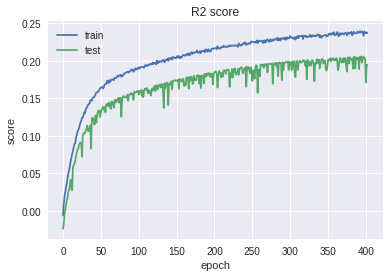

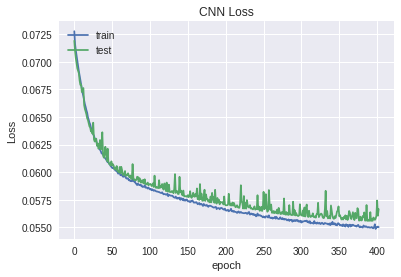

In [19]:
plt.plot(history.history['R2_score'])
plt.plot(history.history['val_R2_score'])
plt.title('R2 score')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
weight = model.get_weights()

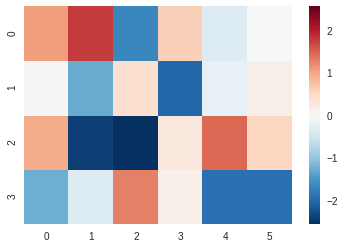

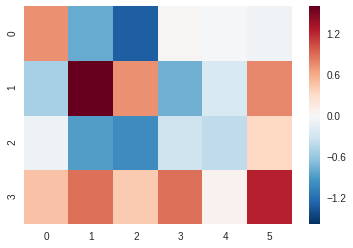

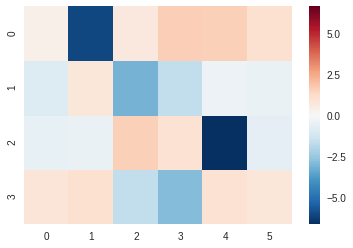

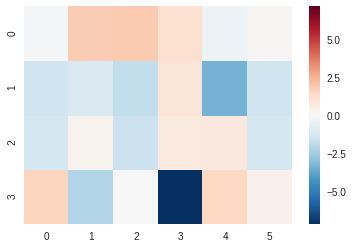

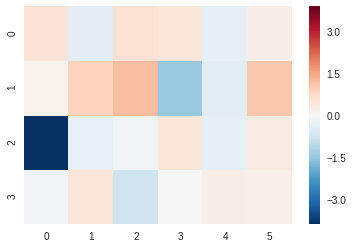

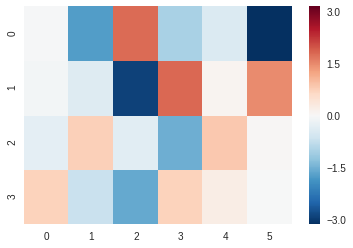

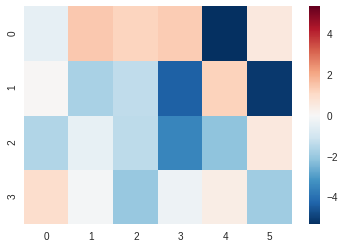

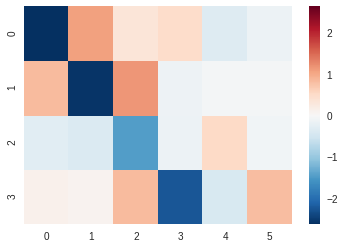

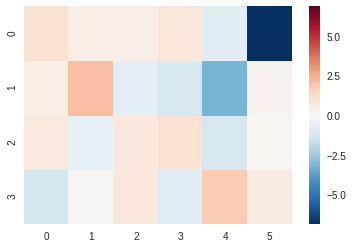

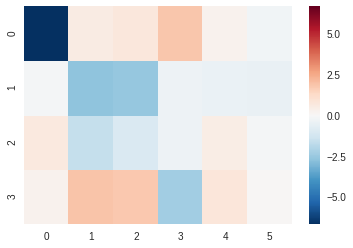

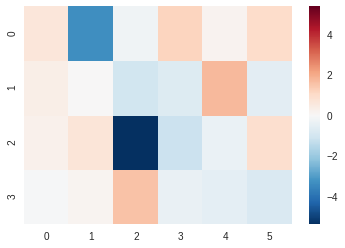

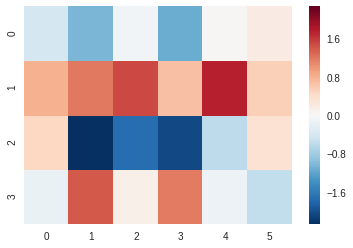

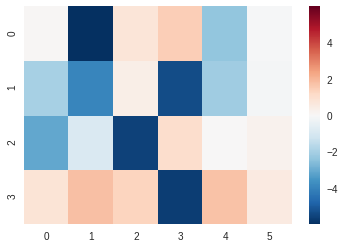

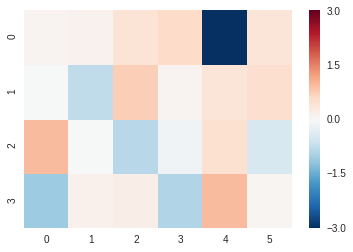

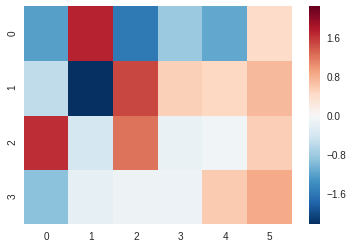

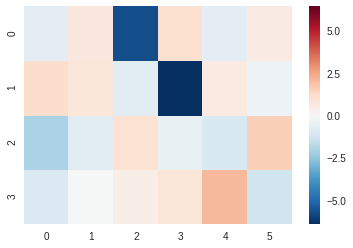

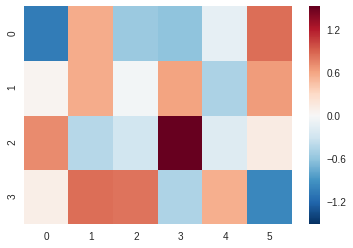

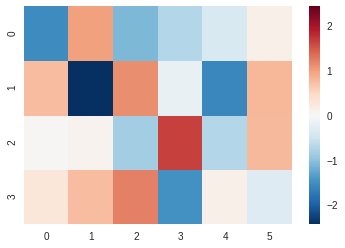

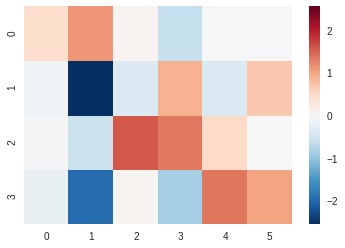

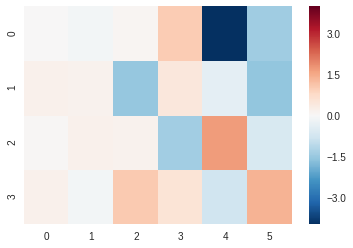

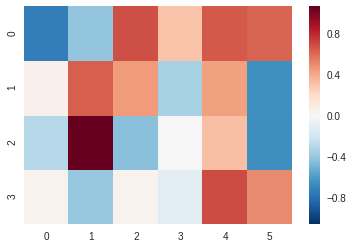

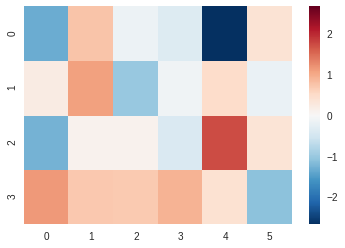

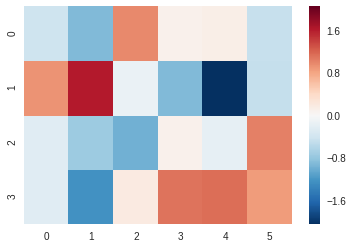

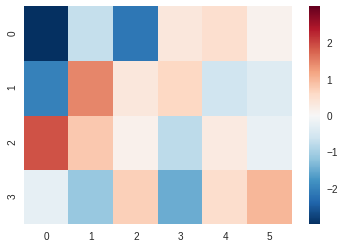

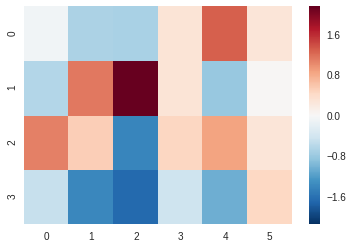

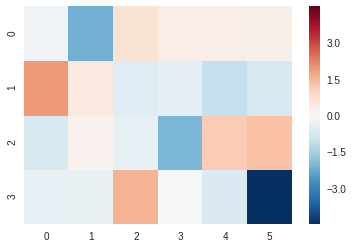

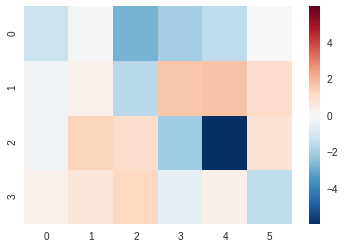

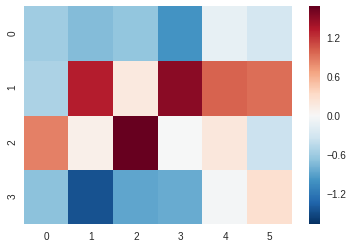

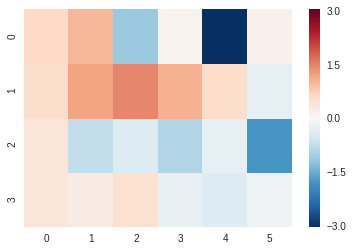

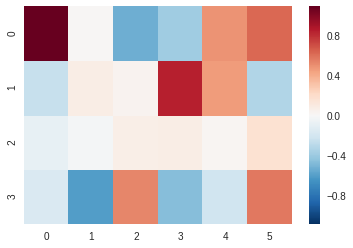

In [21]:
convFilter = weight[0]
for i in range(30):
    ax = sns.heatmap(convFilter[:,:,i].T)
    plt.show()